In [38]:
import numpy as np
import matplotlib.pyplot as plt

observations = ['Dev at 1', 'Dev at 2','Dev at 3','Dev at 4','Dev at 5','Dev at 6', 'No deviant']

# Step 1: Initialize prior belief (biased towards position 4)
def initialize_priors():
    deviant_given_sequence = np.array([1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7])  # Example prior belief
    global_prior = np.array([1/3, 1/3, 1/3])
    return deviant_given_sequence, global_prior

# Step 2: Initialize likelihood matrices
def initialize_likelihoods():
    trial_by_global = np.array([
        # HM FC
        #standard        
        [1, 0],
        #probe
        [0.6, 0.4],
        #catch
        [0.96, 0.04]
    ]).T
    trial_logic = np.array([
        #HM
        [0, 0, 0, 0.33, 0.33, 0.33, 0],
        #FC
        [0, 0, 0, 0, 0, 0, 1]
    ]).T
    return trial_by_global, trial_logic

# Step 3: Initialize helper functions
def sequence_given_state(sequence, trial_by_global, trial_logic):
    deviant_given_state = np.ones(3)
    for i in range(len(sequence)):
        deviant_given_trial = np.array([trial_logic[sequence[i]][0], trial_logic[sequence[i]][1]])
        deviant_given_state *= deviant_given_trial @ trial_by_global

    return deviant_given_state

def state_given_sequence(sequence, prior, trial_by_global, trial_logic):
    SEQUENCE_GIVEN_STATE = sequence_given_state(sequence, trial_by_global, trial_logic)
    state_prob = prior.copy()
    state_prob = SEQUENCE_GIVEN_STATE * state_prob
    norm_state_prob = state_prob / state_prob.sum()
    return norm_state_prob

def future_given_state(trial_by_global, trial_logic):

    return trial_logic @ trial_by_global

def future_given_sequence(sequence, prior, future_given_state, trial_by_global, trial_logic):
    FUTURE_GIVEN_STATE = future_given_state
    STATE_GIVEN_SEQUENCE = state_given_sequence(sequence, prior, trial_by_global, trial_logic)    
    
    return FUTURE_GIVEN_STATE @ STATE_GIVEN_SEQUENCE.T



# Step 4: Gradually update the prior based on the observed deviant location with recency-based decay
def update_priors_simplified(deviant_given_sequence, global_prior, future_given_state, trial_by_global, trial_logic, deviant_position, obs_history):    
    obs_history.append(deviant_position)

    size = len(obs_history)
    index = (size // 250) * 250 if (size // 250) != 0 else (size // 250) * 250 + 1

    clipped_obs_history = obs_history[index - 1: size].copy()

    deviant_given_sequence = future_given_sequence(clipped_obs_history, global_prior, future_given_state, trial_by_global, trial_logic)

    return deviant_given_sequence, obs_history

# Step 5: Run trials and update beliefs
def run_standard_trials(deviant_given_sequence = None, global_prior = None, belief_over_time = None, obs_history = None, n_trials = 1000):
    if (deviant_given_sequence is None or belief_over_time is None or obs_history is None):
        belief_over_time = []  # Store belief at each trial
        obs_history = []  # Track history of observed deviants
    
        # Initialize prior belief (even distribution across all positions initially)
        deviant_given_sequence, global_prior = initialize_priors()
    else:
        belief_over_time = belief_over_time  # Store belief at each trial
        obs_history = obs_history  # Track history of observed deviants
        
        # Initialize prior belief (even distribution across all positions initially)
        deviant_given_sequence = deviant_given_sequence
        global_prior = global_prior
    
    trial_by_global, trial_logic = initialize_likelihoods()
    
    FUTURE_GIVEN_STATE = future_given_state(trial_by_global, trial_logic)

    # Perform the trials
    for trial in range(n_trials):        
        # Randomly choose where the deviant is located (uniform distribution over 6 positions)
        deviant_position = np.random.randint(3, 6)
        
        # After each trial, update the prior based on the deviant position observed in the current trial (gradual update)
        deviant_given_sequence, obs_history = update_priors_simplified(deviant_given_sequence, global_prior, FUTURE_GIVEN_STATE, trial_by_global, trial_logic, deviant_position, obs_history)
        
        # Record the belief after this trial
        belief_over_time.append(deviant_given_sequence.copy())
    
    return deviant_given_sequence, belief_over_time, obs_history

# Step 6: Plot the belief evolution over time
def plot_belief_evolution(belief_over_time, trials_to_demarcate=None, labels=None):
    plt.figure(figsize=(10, 6))
    
    # Loop through positions, but label position 7 as "No deviant"
    for i in range(6):  # Only plot positions 1 through 6 (0 to 5)
        plt.plot(belief_over_time[:, i], label=f"Position {i+1}")
    
    # Plot position 7 as "No deviant"
    plt.plot(belief_over_time[:, 6], label="No deviant", linestyle='dashed', color='black')

    # If trials_to_demarcate and labels are provided, add vertical lines and different labels
    if trials_to_demarcate is not None and labels is not None:
        for trial, label in zip(trials_to_demarcate, labels):
            plt.axvline(x=trial, color='red', linestyle='--', label=None)
            plt.text(trial + 5, 0.45, label, color='red')  # Adjust position as needed
    
    plt.xlabel("Trial")
    plt.ylabel("Belief")
    plt.title("Evolution of Belief Over Time (Gradual Updates)")
    plt.legend()
    plt.show()

In [39]:
# Step 5: Run trials and update beliefs
def run_probe_trials(deviant_given_sequence = None, global_prior = None, belief_over_time = None, obs_history = None, n_trials = 1000):
    if (deviant_given_sequence is None or belief_over_time is None or obs_history is None):
        belief_over_time = []  # Store belief at each trial
        obs_history = []  # Track history of observed deviants
    
        # Initialize prior belief (even distribution across all positions initially)
        deviant_given_sequence, global_prior = initialize_priors()
    else:
        belief_over_time = belief_over_time  # Store belief at each trial
        obs_history = obs_history  # Track history of observed deviants
        
        # Initialize prior belief (even distribution across all positions initially)
        deviant_given_sequence = deviant_given_sequence
        global_prior = global_prior
    
    trial_by_global, trial_logic = initialize_likelihoods()
    
    FUTURE_GIVEN_STATE = future_given_state(trial_by_global, trial_logic)

    # Perform the trials
    for trial in range(n_trials):        
        # Randomly choose where the deviant is located (uniform distribution over 6 positions)
        positions = [3, 4, 5, 6]
        probabilities = [0.95/3, 0.95/3, 0.95/3, 0.05]  # 60% for positions 3, 4, 5; 40% for position 7
        deviant_position = np.random.choice(positions, size=1, p=probabilities)[0]
        
        # After each trial, update the prior based on the deviant position observed in the current trial (gradual update)
        deviant_given_sequence, obs_history = update_priors_simplified(deviant_given_sequence, global_prior, FUTURE_GIVEN_STATE, trial_by_global, trial_logic, deviant_position, obs_history)
        
        # Record the belief after this trial
        belief_over_time.append(deviant_given_sequence.copy())
    
    return deviant_given_sequence, belief_over_time, obs_history

In [40]:
# Step 5: Run trials and update beliefs
def run_catch_trials(deviant_given_sequence = None, global_prior = None, belief_over_time = None, obs_history = None, n_trials = 1000):
    if (deviant_given_sequence is None or belief_over_time is None or obs_history is None):
        belief_over_time = []  # Store belief at each trial
        obs_history = []  # Track history of observed deviants
    
        # Initialize prior belief (even distribution across all positions initially)
        deviant_given_sequence, global_prior = initialize_priors()
    else:
        belief_over_time = belief_over_time  # Store belief at each trial
        obs_history = obs_history  # Track history of observed deviants
        
        # Initialize prior belief (even distribution across all positions initially)
        deviant_given_sequence = deviant_given_sequence
        global_prior = global_prior
    
    trial_by_global, trial_logic = initialize_likelihoods()
    
    FUTURE_GIVEN_STATE = future_given_state(trial_by_global, trial_logic)

    # Perform the trials
    for trial in range(n_trials):        
        positions = [3, 4, 5, 6]
        probabilities = [0.6/3, 0.6/3, 0.6/3, 0.4]  # 60% for positions 3, 4, 5; 40% for position 7
        deviant_position = np.random.choice(positions, size=1, p=probabilities)[0]
        
        # After each trial, update the prior based on the deviant position observed in the current trial (gradual update)
        deviant_given_sequence, obs_history = update_priors_simplified(deviant_given_sequence, global_prior, FUTURE_GIVEN_STATE, trial_by_global, trial_logic, deviant_position, obs_history)
        
        # Record the belief after this trial
        belief_over_time.append(deviant_given_sequence.copy())
    
    return deviant_given_sequence, belief_over_time, obs_history

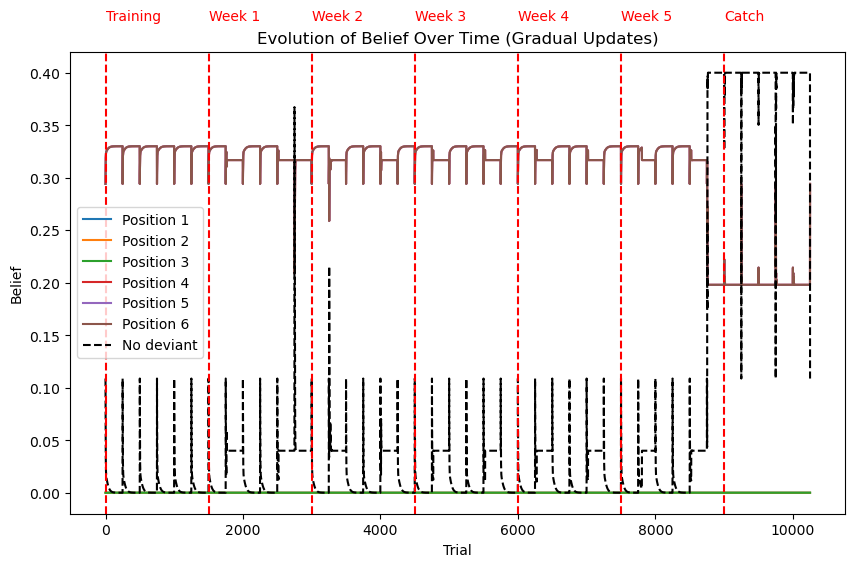

In [41]:
standard_prior_belief, standard_belief_over_time, standard_obs_history = run_standard_trials(None, None, None, None, n_trials = 1500)

global_prior = np.array([1/3, 1/3, 1/3])

for i in range(5):
    standard_prior_belief, standard_belief_over_time, standard_obs_history = run_standard_trials(standard_prior_belief.copy(), global_prior, standard_belief_over_time.copy(), standard_obs_history.copy(), n_trials = 250)
    probe_prior_belief, probe_belief_over_time, probe_obs_history = run_probe_trials(standard_prior_belief.copy(), global_prior, standard_belief_over_time.copy(), standard_obs_history.copy(), n_trials = 250)
    standard_prior_belief, standard_belief_over_time, standard_obs_history = run_standard_trials(probe_prior_belief.copy(), global_prior, probe_belief_over_time.copy(), probe_obs_history.copy(), n_trials = 500)
    probe_prior_belief, probe_belief_over_time, probe_obs_history = run_probe_trials(standard_prior_belief.copy(), global_prior, standard_belief_over_time.copy(), standard_obs_history.copy(), n_trials = 250)
    standard_prior_belief, standard_belief_over_time, standard_obs_history = run_standard_trials(probe_prior_belief.copy(), global_prior, probe_belief_over_time.copy(), probe_obs_history.copy(), n_trials = 250)

catch_prior_belief, catch_belief_over_time, catch_deviant_positions = run_catch_trials(probe_prior_belief.copy(), global_prior, probe_belief_over_time.copy(), probe_obs_history.copy(), n_trials = 1500)


trials_to_demarcate = [0, 1500, 3000, 4500, 6000, 7500, 9000]  # Example: demarcate trials 100, 500, and 800
labels = ["Training", "Week 1", "Week 2", "Week 3", "Week 4", "Week 5", "Catch"]

catch_belief_over_time_graph = np.array(catch_belief_over_time).copy()
# Plot the belief evolution over time
plot_belief_evolution(catch_belief_over_time_graph, trials_to_demarcate, labels)